In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data
from nilearn import datasets, plotting
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from multi_head_gat_with_edge_features import GATWithEdgeFeatures
import torch.nn as nn
from tqdm import tqdm
import time

In [2]:
# CONSTANTS
DATASET_PATH = '../../data/ppmi_corr_116.pth'
STUDY_CONNECTOME_INDEX = 20
NODE_FEATURES = 5
EDGE_FEATURES = 4

In [3]:
# HYPERPARAMETERS
SUPPRESS_THRESHOLD = 0.3
ATTENTION_HEADS = 8
EPOCHS = 50
LEARNING_RATE = 0.0001
FOLDS = 5
BATCH_SIZE = 32
DROP_OUT = 0.6
ALPHA = 0.2
LAYERS = 2
HIDDEN = 8
OUT_FEATURES = 4

In [4]:
# ATLAS SPECIFIC
aal_atlas = datasets.fetch_atlas_aal(version='SPM12')
atlas_filename = aal_atlas.maps
labels = aal_atlas.labels
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)
colors = [
    '#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#00FFFF', '#800000', '#808000', '#008000', '#800080',
    '#008080', '#000080', '#FF4500', '#DA70D6', '#7FFF00', '#D2691E', '#FF69B4', '#8A2BE2', '#5F9EA0', '#D2B48C',
    '#FFE4B5', '#BDB76B', '#F0E68C', '#FFD700', '#ADFF2F', '#32CD32', '#98FB98', '#AFEEEE', '#4682B4', '#6A5ACD',
    '#7B68EE', '#00FA9A', '#48D1CC', '#6495ED', '#1E90FF', '#FF6347', '#FF7F50', '#F08080', '#E9967A', '#FA8072',
    '#FF1493', '#C71585', '#DB7093', '#B22222', '#FF4500', '#DAA520', '#B8860B', '#CD5C5C', '#4B0082', '#FF8C00',
    '#FFDAB9', '#E6E6FA', '#FFF0F5', '#FFE4E1', '#FAEBD7', '#F5F5DC', '#FFFACD', '#FFEBCD'
]

In [5]:
ppmi_dataset = torch.load(DATASET_PATH)
connectivity_matrices = ppmi_dataset['data'].numpy()
connectivity_labels = ppmi_dataset['class_label'].numpy().reshape(-1, 1)
connectivity_matrices.shape, connectivity_labels.shape

((209, 116, 116), (209, 1))

Mean: 0.09152094228343459
Min: -0.7707168807098154
Max: 1.0
Variance: 0.10314659885801204
Standard Deviation: 0.3211644420822642


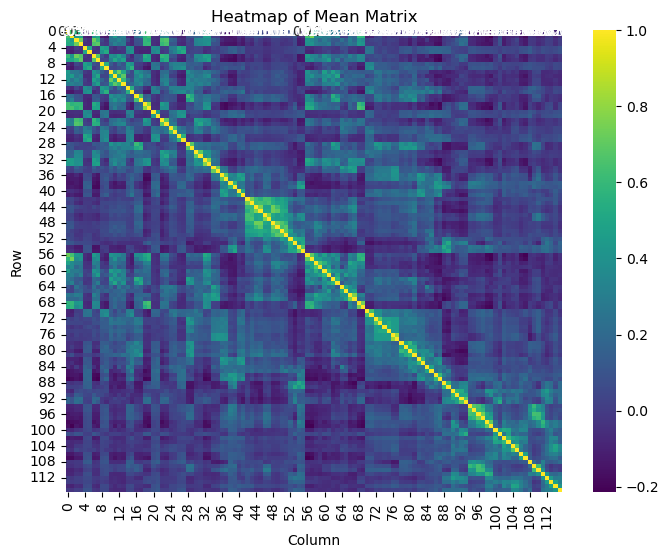

In [6]:
# Calculate statistics for the whole population
mean = np.mean(connectivity_matrices)
min_val = np.min(connectivity_matrices)
max_val = np.max(connectivity_matrices)
variance = np.var(connectivity_matrices)
std_dev = np.std(connectivity_matrices)

mean_matrix = np.mean(connectivity_matrices, axis=0)

# Print the results
print(f"Mean: {mean}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Variance: {variance}")
print(f"Standard Deviation: {std_dev}")
# Plot a heatmap of the resulting mean matrix
plt.figure(figsize=(8, 6))
sns.heatmap(mean_matrix, annot=True, cmap="viridis", cbar=True)
plt.title("Heatmap of Mean Matrix")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

In [7]:
def suppress_interhemispheric_connectivity(matrix):
    """
    Suppresses the interhemispheric connections of the given connectivity matrix.
    """
    num_regions = matrix.shape[0] // 2
    for i in range(num_regions):
            left_region_index = 2 * i
            right_region_index = 2 * i + 1
            for j in range(num_regions):
                if j != i:
                    left_region_other = 2 * j
                    right_region_other = 2 * j + 1
                    matrix[left_region_index, right_region_other] = 0
                    matrix[right_region_index, left_region_other] = 0
    return matrix

In [8]:
connectivity_matrices_inter_suppressed = np.array([suppress_interhemispheric_connectivity(matrix) for matrix in connectivity_matrices])

Mean: 0.05543771541301947
Min: -0.7636596304999513
Max: 1.0
Variance: 0.05986909928301475
Standard Deviation: 0.24468162841336238


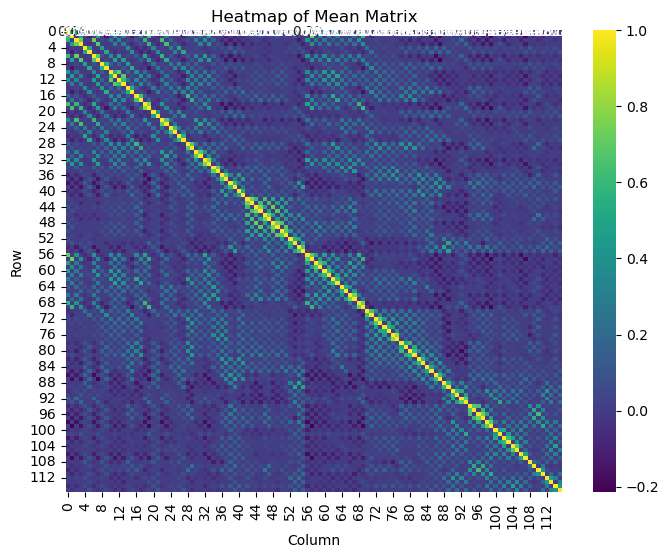

In [9]:
# Calculate statistics for the whole population
mean = np.mean(connectivity_matrices_inter_suppressed)
min_val = np.min(connectivity_matrices_inter_suppressed)
max_val = np.max(connectivity_matrices_inter_suppressed)
variance = np.var(connectivity_matrices_inter_suppressed)
std_dev = np.std(connectivity_matrices_inter_suppressed)

mean_matrix = np.mean(connectivity_matrices_inter_suppressed, axis=0)

# Print the results
print(f"Mean: {mean}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Variance: {variance}")
print(f"Standard Deviation: {std_dev}")
# Plot a heatmap of the resulting mean matrix
plt.figure(figsize=(8, 6))
sns.heatmap(mean_matrix, annot=True, cmap="viridis", cbar=True)
plt.title("Heatmap of Mean Matrix")
plt.xlabel("Column")
plt.ylabel("Row")
plt.show()

In [10]:
def construct_graph(matrix, threshold=0.3):
    G = nx.Graph()
    num_nodes = matrix.shape[0]
    # Add nodes with connectivity strength and hemisphere as features
    for i in range(num_nodes):
        hemisphere = 0 if i % 2 == 0 else 1  # Assuming alternating arrangement
        G.add_node(i, strength=matrix[i, :].mean(), hemisphere=hemisphere, coords=coords[i], color=colors[i//2], label=labels[i])
    
    # Add edges with connectivity attribute and inter/intra-hemispheric feature
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if abs(matrix[i, j]) > threshold:
                interhemispheric = 1 if (i % 2 != j % 2) else 0
                G.add_edge(i, j, weight=matrix[i, j], interhemispheric=interhemispheric)
    # Add additional node features
    for node in G.nodes():
        G.nodes[node]['degree'] = G.degree[node]
    clustering_coeffs = nx.clustering(G)
    for node, coeff in clustering_coeffs.items():
        G.nodes[node]['clustering'] = coeff
    betweenness = nx.betweenness_centrality(G)
    for node, centrality in betweenness.items():
        G.nodes[node]['betweenness'] = centrality
    # Add additional edge features
    edge_betweenness = nx.edge_betweenness_centrality(G)
    for u, v, data in G.edges(data=True):
        data['edge_betweenness'] = edge_betweenness[(u, v)]
    max_weight = max([data['weight'] for _, _, data in G.edges(data=True)])
    for u, v, data in G.edges(data=True):
        data['normalized_weight'] = data['weight'] / max_weight
    return G

def convert_to_pyg_data(G):
    edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor([[G[u][v]['weight'], G[u][v]['interhemispheric'], G[u][v]['edge_betweenness'], G[u][v]['normalized_weight']] for u, v in G.edges], dtype=torch.float)
    # Extract node features
    node_features = np.array([[G.nodes[i]['strength'], G.nodes[i]['hemisphere'], G.nodes[i]['degree'], G.nodes[i]['clustering'], G.nodes[i]['betweenness']] for i in G.nodes])
    x = torch.tensor(node_features, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data


In [11]:
graphs = [construct_graph(matrix, SUPPRESS_THRESHOLD) for matrix in connectivity_matrices_inter_suppressed]

In [12]:
connectome = graphs[STUDY_CONNECTOME_INDEX]
connectome_adj = nx.adjacency_matrix(connectome).todense()
connectome_coords = [connectome.nodes[node]['coords'] for node in connectome.nodes()]
connectome_colors = [connectome.nodes[node]['color'] for node in connectome.nodes()]
print(f'Connectome:\n\tNumber of nodes: {connectome.number_of_nodes()}\n\tNumber of edges: {connectome.number_of_edges()}')

Connectome:
	Number of nodes: 116
	Number of edges: 393


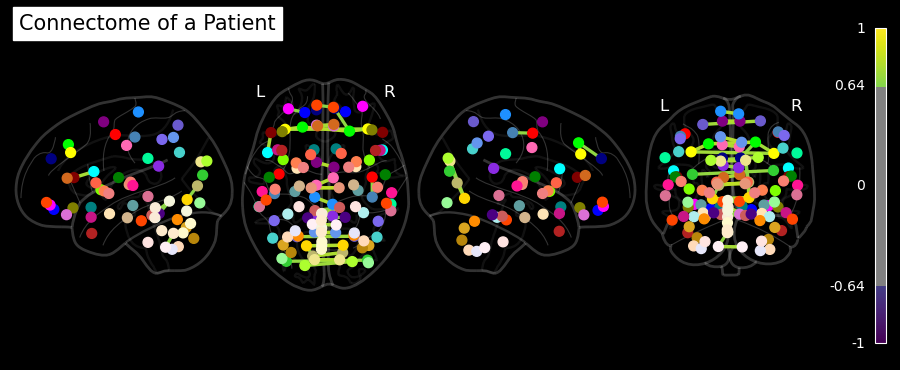

In [13]:
plotting.plot_connectome(adjacency_matrix=connectome_adj, node_coords=connectome_coords, node_color=connectome_colors, edge_cmap='viridis', edge_vmin=-1, edge_vmax=1, edge_threshold='99.5%', display_mode='lzry', title=f'Connectome of a {"Patient" if connectivity_labels[STUDY_CONNECTOME_INDEX] == 2 else "Non-Patient"}', colorbar=True, alpha=0.2, black_bg=True);

In [14]:
class BrainConnectivityDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        data = self.graphs[idx]
        data.y = self.labels[idx]
        return data

In [15]:
def create_data_loaders(graphs, labels, n_splits=5, batch_size=32):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    loaders = []
    
    for train_index, test_index in skf.split(graphs, labels):
        train_graphs = [graphs[i] for i in train_index]
        train_labels = labels[train_index]
        test_graphs = [graphs[i] for i in test_index]
        test_labels = labels[test_index]
        
        train_dataset = BrainConnectivityDataset(train_graphs, train_labels)
        test_dataset = BrainConnectivityDataset(test_graphs, test_labels)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        loaders.append((train_loader, test_loader))
    
    return loaders

In [16]:
graph_data_list = [convert_to_pyg_data(G) for G in graphs]
labels = torch.tensor(connectivity_labels, dtype=torch.long)
data_loaders = create_data_loaders(graph_data_list, labels, n_splits=FOLDS, batch_size=BATCH_SIZE)

In [17]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in tqdm(train_loader, desc='Training', leave=False):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1))  # Flatten the target labels
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_loader.dataset)

def test_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Testing', leave=False):
            data = data.to(device)
            out = model(data)
            loss = criterion(out, data.y.view(-1))  # Flatten the target labels
            total_loss += loss.item() * data.num_graphs
            pred = out.argmax(dim=1)
            correct += pred.eq(data.y.view(-1)).sum().item()
    return total_loss / len(test_loader.dataset), correct / len(test_loader.dataset)

# Training with Cross-Validation
for fold, (train_loader, test_loader) in enumerate(data_loaders):
    model = GATWithEdgeFeatures(
        in_features=NODE_FEATURES, 
        hidden_features=HIDDEN, 
        out_features=OUT_FEATURES, 
        edge_features=EDGE_FEATURES, 
        heads=ATTENTION_HEADS, 
        dropout=DROP_OUT, 
        alpha=ALPHA, 
        num_classes=4, 
        num_layers=LAYERS
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(EPOCHS):  # Adjust the number of epochs as needed
        start_time = time.time()
        train_loss = train_model(model, train_loader, optimizer, criterion, device)
        test_loss, test_acc = test_model(model, test_loader, criterion, device)
        elapsed_time = time.time() - start_time
        print(f'Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Time: {elapsed_time:.2f}s')


Fold 1, Epoch 1, Train Loss: 324.0213, Test Loss: 217.9728, Test Acc: 0.0714, Time: 72.68s


Fold 1, Epoch 2, Train Loss: 323.2129, Test Loss: 214.6219, Test Acc: 0.0714, Time: 68.96s


Fold 1, Epoch 3, Train Loss: 316.5534, Test Loss: 211.1460, Test Acc: 0.0714, Time: 72.39s


Fold 1, Epoch 4, Train Loss: 309.1773, Test Loss: 207.7701, Test Acc: 0.0714, Time: 73.80s


Fold 1, Epoch 5, Train Loss: 311.4260, Test Loss: 205.0823, Test Acc: 0.0714, Time: 71.77s


Fold 1, Epoch 6, Train Loss: 304.9931, Test Loss: 202.7926, Test Acc: 0.0714, Time: 68.25s


Fold 1, Epoch 7, Train Loss: 295.8299, Test Loss: 200.3862, Test Acc: 0.0714, Time: 71.59s


Fold 1, Epoch 8, Train Loss: 299.5881, Test Loss: 198.0798, Test Acc: 0.0714, Time: 71.04s


Fold 1, Epoch 9, Train Loss: 292.1976, Test Loss: 195.7265, Test Acc: 0.0714, Time: 70.39s


Fold 1, Epoch 10, Train Loss: 290.1651, Test Loss: 193.5717, Test Acc: 0.0714, Time: 68.73s


KeyboardInterrupt: 